In [112]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

In [113]:
N = 1009 # dimensions of Hilbert space

U = np.zeros((N, N), dtype = complex)
alpha = 0.5
beta = 0.5
K = 1 # kicking strength

In [114]:
# create the floquet operator

# first step: make the DFT vector and perform a DFT

m = np.arange(N)
dm = np.exp((-1j * np.pi * (m + beta)**2)/N)

f = scp.fft.ifft(dm)

In [115]:
# next step is to build the operator now

n = m.copy()
kn = np.exp((1j * N * K)/(2*np.pi) * np.cos(2*np.pi*(n+alpha)/N)) # kick operator
for i in range(N):
    for k in range(N):
        U[i, k] = kn[i] * np.exp((1j * 2 * np.pi/N)*beta*((i-k)%N)) * f[(i-k)%N]

In [116]:
# a try to see how to visualize the wigner function using the eigenstates of the Floquet operator as the bassi

"""
Explicitly builds the entire phase point operator for each coordinate. that is too much computation and not good for memory.
"""

def phase_point(a1, a2, N):
    A = np.zeros((N, N), dtype = complex) # phase point operator for each coordinate (a1, a2)
    for k in range(N):
        for l in range(N):
            if (k + l)%N == (2 * a1)%N:
                A[k, l] = np.exp(1j * (2 * np.pi * a2 * (k-l))/N)

    return A

def wigner_function(psi):
    density = np.outer(psi, psi.conj())
    N = len(psi)
    a1 = np.arange(N)
    a2 = np.arange(N)
    W = np.zeros((N, N))

    for k in range(N):
        for l in range(N):
            A_kl = phase_point(a1[k], a2[l], N)
            W[k, l] = (1/N) * np.trace(density @ A_kl)

    return W

In [117]:
def wigner_fast(psi):
    psi = psi.reshape(-1)
    N = len(psi)
    rho = np.outer(psi, psi.conj())      # density matrix

    # indices k, l
    k = np.arange(N).reshape(N,1)
    l = np.arange(N).reshape(1,N)

    # all possible (k+l) mod N
    S = (k + l) % N

    # all possible (k-l) mod N
    D = (k - l) % N

    # precompute rho(k,l) once
    R = rho

    # output Wigner function
    W = np.zeros((N, N), dtype=complex)

    # For each a1, pick out the stripe where k+l = 2*a1
    for a1 in range(N):
        mask = (S == (2*a1) % N)              # boolean mask for that diagonal stripe
        vals = np.zeros(N, dtype=complex)     # values for all a2 for this a1

        # pick the (k,l) pairs in this stripe
        R_stripe = R[mask]                    # these are rho(k,l)
        D_stripe = D[mask]                    # these are (k-l)

        # compute FFT along a2 direction:
        # sum over stripe entries: rho(k,l) * exp(2πi a2 (k-l)/N)
        # which is exactly the DFT of rho(k,l) grouped by (k-l)
        # so build an accumulator of size N for each (k-l)
        tmp = np.zeros(N, dtype=complex)
        for r, d in zip(R_stripe, D_stripe):
            tmp[d] += r

        # Now vals[a2] = tmp_d * exp(2π i a2 d / N)
        W[a1] = (1/N) * np.fft.fft(tmp)

    return W.real

In [120]:
eigval, eigvec = np.linalg.eig(U)

W_phin = wigner_fast(eigvec[:, 0])

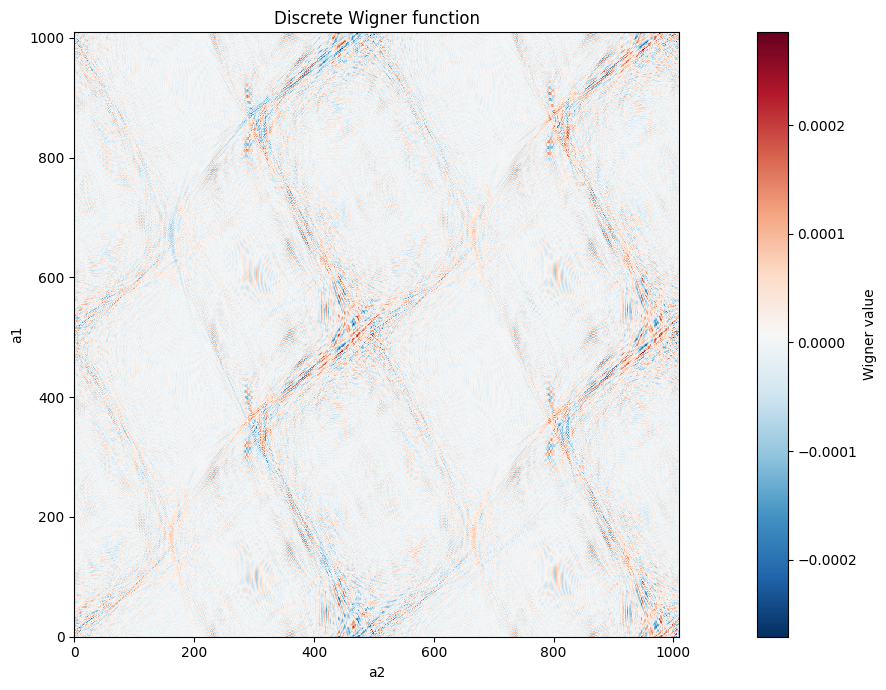

In [121]:
plt.figure(figsize=(16,7))
plt.imshow(W_phin, cmap='RdBu_r', origin='lower', extent=[0, W_phin.shape[0], 0, W_phin.shape[1]],interpolation='nearest')
plt.colorbar(label='Wigner value')
plt.xlabel('a2')
plt.ylabel('a1')
plt.title(f'Discrete Wigner function')
plt.tight_layout()
plt.show()